FX Risk

C:\Users\JYB\AppData\Local\Temp\ipykernel_3292\3455777940.py:60: UserWarning: Glyph 128177 (\N{CURRENCY EXCHANGE}) missing from current font.
  plt.tight_layout()


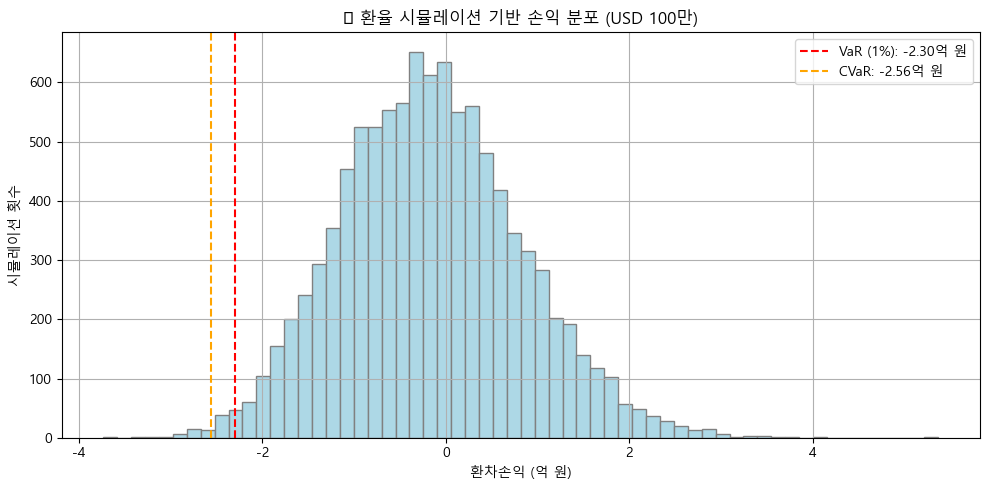

{'최악 1% 손실 (VaR)': 229964872.0013009,
 'Conditional VaR (평균)': 255838152.86683938,
 '헤지로 방지한 평균 손실': 16356933.50228106}

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Windows에서 한글이 잘 보이는 기본 폰트 설정 (예: 'Malgun Gothic')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 음수 부호 깨짐 방지


# 시드 설정
np.random.seed(42)

# 1️⃣ 시뮬레이션 설정
initial_fx = 1300  # 현재 환율 (KRW/USD)
mu = -0.0002       # 일간 기대수익률 (환율 하락 기대)
sigma = 0.01       # 일간 환율 변동성 (1%)
days = 60          # 시뮬레이션 기간 (60일)
num_sim = 10000    # 시뮬레이션 횟수

# 2️⃣ 몬테카를로 시뮬레이션: GBM 기반 환율 경로
sim_fx = np.zeros((days, num_sim))
sim_fx[0] = initial_fx

for t in range(1, days):
    z = np.random.standard_normal(num_sim)
    sim_fx[t] = sim_fx[t - 1] * np.exp((mu - 0.5 * sigma**2) + sigma * z)

# 3️⃣ 환차손익 계산 (외화 수취 가정: $1,000,000)
usd_exposure = 1_000_000
final_fx = sim_fx[-1]
krw_received = final_fx * usd_exposure
krw_change = krw_received - initial_fx * usd_exposure

# 4️⃣ VaR 계산 (1% 손실 기준)
confidence_level = 0.99
fx_var = -np.percentile(krw_change, (1 - confidence_level) * 100)
fx_cvar = -krw_change[krw_change <= -fx_var].mean()

# 5️⃣ 헤지 효과 비교 (선물환 고정 환율: 1300원)
hedged_krw_received = np.full_like(final_fx, initial_fx * usd_exposure)
hedge_diff = hedged_krw_received - krw_received

# 결과 요약
summary = {
    "최악 1% 손실 (VaR)": fx_var,
    "Conditional VaR (평균)": fx_cvar,
    "헤지로 방지한 평균 손실": np.mean(hedge_diff)
}

# 6️⃣ 시각화
plt.figure(figsize=(10, 5))
plt.hist(krw_change / 1e8, bins=60, color='lightblue', edgecolor='gray')
plt.axvline(-fx_var / 1e8, color='red', linestyle='--', label=f"VaR (1%): -{fx_var/1e8:.2f}억 원")
plt.axvline(-fx_cvar / 1e8, color='orange', linestyle='--', label=f"CVaR: -{fx_cvar/1e8:.2f}억 원")
plt.title("💱 환율 시뮬레이션 기반 손익 분포 (USD 100만)")
plt.xlabel("환차손익 (억 원)")
plt.ylabel("시뮬레이션 횟수")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

summary


In [3]:
# 다양한 조건 설정
days_list = [10, 30, 60, 120]  # 시뮬레이션 기간 (일)
exposures = [500_000, 1_000_000, 2_000_000]  # 외화 노출 (USD)

# 결과 저장
results = []

# 시뮬레이션 반복
for days in days_list:
    for usd_exposure in exposures:
        sim_fx = np.zeros((days, num_sim))
        sim_fx[0] = initial_fx

        for t in range(1, days):
            z = np.random.standard_normal(num_sim)
            sim_fx[t] = sim_fx[t - 1] * np.exp((mu - 0.5 * sigma**2) + sigma * z)

        final_fx = sim_fx[-1]
        krw_received = final_fx * usd_exposure
        krw_change = krw_received - initial_fx * usd_exposure

        # VaR 계산
        fx_var = -np.percentile(krw_change, (1 - confidence_level) * 100)
        fx_cvar = -krw_change[krw_change <= -fx_var].mean()

        results.append({
            "기간(일)": days,
            "USD 노출금액": usd_exposure,
            "VaR (1%)": round(fx_var),
            "CVaR": round(fx_cvar)
        })

# 데이터프레임으로 정리
df_var_compare = pd.DataFrame(results)
import ace_tools as tools; tools.display_dataframe_to_user(name="기간/노출별 VaR 비교", dataframe=df_var_compare)


ModuleNotFoundError: No module named 'ace_tools'

In [4]:
# 데이터프레임 출력
print(df_var_compare)

# 또는 Jupyter 스타일 출력
df_var_compare.style.format({
    "VaR (1%)": "{:,.0f}",
    "CVaR": "{:,.0f}"
})


    기간(일)  USD 노출금액   VaR (1%)       CVaR
0      10    500000   44400383   50100913
1      10   1000000   89662860  102098789
2      10   2000000  187017928  213045475
3      30    500000   81575794   90547304
4      30   1000000  160677589  185305651
5      30   2000000  319309101  363582983
6      60    500000  110925704  124432921
7      60   1000000  230187159  257249670
8      60   2000000  459944912  513623373
9     120    500000  160312811  180812354
10    120   1000000  316505653  358816560
11    120   2000000  648542520  718673716


,기간(일),USD 노출금액,VaR (1%),CVaR
0,10,500000,"44,400,383","50,100,913"
1,10,1000000,"89,662,860","102,098,789"
2,10,2000000,"187,017,928","213,045,475"
3,30,500000,"81,575,794","90,547,304"
4,30,1000000,"160,677,589","185,305,651"
5,30,2000000,"319,309,101","363,582,983"
6,60,500000,"110,925,704","124,432,921"
7,60,1000000,"230,187,159","257,249,670"
8,60,2000000,"459,944,912","513,623,373"
9,120,500000,"160,312,811","180,812,354"
